In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [ ]:
from torch_geometric.utils import to_networkx
import matplotlib.colors as colors
import matplotlib.cm as cmx
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
def plotmutag(data):
  cmap = colors.ListedColormap(['blue', 'black','red','yellow','orange','green','purple'])
  ColorLegend = {'Carbon': 0,'Nitrogen': 1,'Oxygen': 2,'Fluorine': 3,'Iodine':4,'Chlorine':5,'Bromine':6}
  cNorm  = colors.Normalize(vmin=0, vmax=6)
  scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
  #print(cmap.colors)

  exampledata=data
  exfeatures=exampledata.x
  #exlabel=exampledata.y
  examplelabels=torch.argmax(exfeatures,dim=1)
  #print(exlabel)
  examplegraph=to_networkx(exampledata,to_undirected=True)
  f = plt.figure(2,figsize=(8,8))
  ax = f.add_subplot(1,1,1)
  for label in ColorLegend:
      ax.plot([0],[0],color=scalarMap.to_rgba(ColorLegend[label]),label=label)
  nx.draw_networkx(examplegraph, node_size=150,node_color=examplelabels,cmap=cmap,vmin=0,vmax=6,with_labels=False,ax=ax)
  plt.legend(fontsize=12,loc='best')
  plt.show()



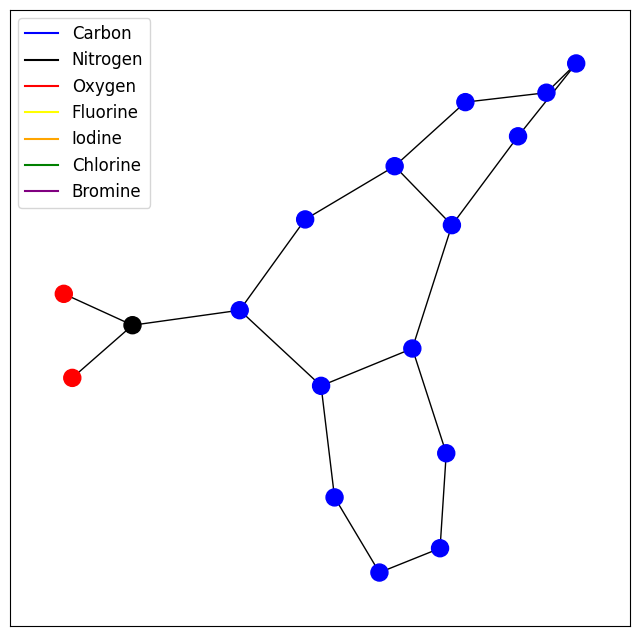

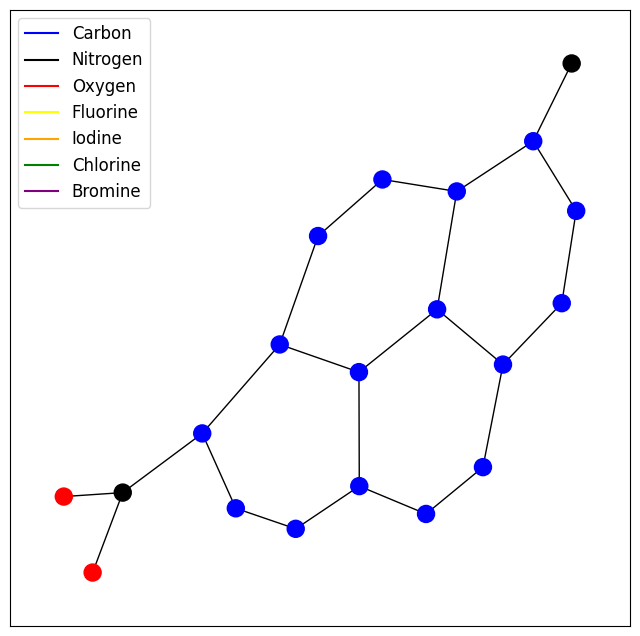

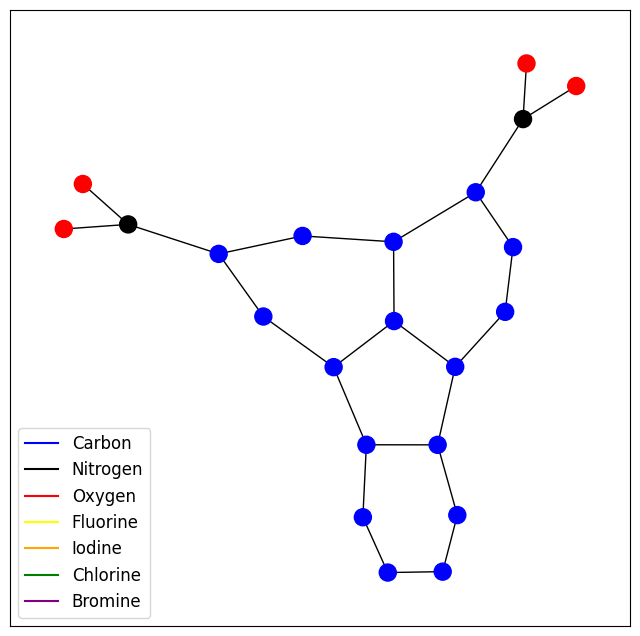

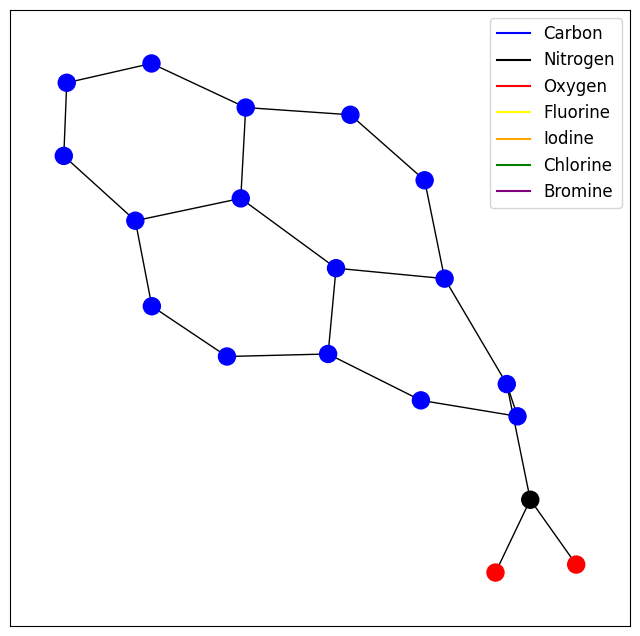

In [ ]:
for data in dataset[10:15]:
  if(data.y==1):
    plotmutag(data)

In [ ]:
import random
torch.manual_seed(12345)
dataset.shuffle(dataset)

train_dataset = dataset[:170]
test_dataset = dataset[170:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 170
Number of test graphs: 18


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2590], x=[1158, 7], edge_attr=[2590, 4], y=[64], batch=[1158], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2526], x=[1149, 7], edge_attr=[2526, 4], y=[64], batch=[1149], ptr=[65])

Step 3:
Number of graphs in the current batch: 42
DataBatch(edge_index=[2, 1610], x=[737, 7], edge_attr=[1610, 4], y=[42], batch=[737], ptr=[43])



# Defining the Classifier

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNEncoder(torch.nn.Module):
    def __init__(self, inputdim,hidden_channels):
        super(GCNEncoder, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(inputdim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(0.5)
        self.leaky_relu = torch.nn.LeakyReLU(0.2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = self.leaky_relu(x)
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        x = self.bn(x)
        x = F.dropout(x, p=0.5, training=self.training)
        return x

class LinearClassifier(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)
class CombinedModel(torch.nn.Module):
    def __init__(self,inputdim, hidden_channels, num_classes):
        super(CombinedModel, self).__init__()
        self.encoder = GCNEncoder(inputdim,hidden_channels)
        self.classifier = LinearClassifier(input_dim=hidden_channels, num_classes=num_classes)

    def forward(self, x, edge_index, batch):
        # Get the embeddings from the encoder
        embeddings = self.encoder(x, edge_index, batch)

        # Get the logits from the classifier
        logits = self.classifier(embeddings)

        return embeddings, logits
num_features=7
inputdim=num_features
model=CombinedModel(inputdim, hidden_channels=64,num_classes=2)


# Training Loop of The Classifier

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Add a learning rate scheduler
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
# def train():
#     model.train()

#     for epoch in range(num_epochs):
#         for data in train_loader:  # Iterate in batches over the training dataset.
#             embedding,  out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#             #print(out)
#             loss = criterion(out, data.y)  # Compute the loss.
#             loss.backward()  # Derive gradients.
#             optimizer.step()  # Update parameters based on gradients.
#             optimizer.zero_grad()  # Clear gradients.

#         # Update the learning rate scheduler
#         scheduler.step()

#         # Print the current learning rate every epoch (optional)
#         print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {scheduler.get_last_lr()[0]}",loss)
#         # train_acc = test(train_loader)
#         # test_acc = test(test_loader)
#         # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
def train():
    model.train()

    for epoch in range(num_epochs):
        for data in train_loader:  # Iterate in batches over the training dataset.
            # Forward pass
            x, edge_index, batch = data.x, data.edge_index, data.batch
            embedding, out = model(x, edge_index, batch)

            # Compute the loss
            loss = criterion(out, data.y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the learning rate scheduler
        scheduler.step()

        # Print the current learning rate and loss every epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {scheduler.get_last_lr()[0]}, Loss: {loss.item()}")

# Set the number of epochs
num_epochs = 1600

# Call the training loop
train()


# # Set the number of epochs
# num_epochs = 800

# # Call the training loop
# train()



Epoch 1/1600, Learning Rate: 0.0099, Loss: 0.583014726638794
Epoch 2/1600, Learning Rate: 0.009801, Loss: 0.5798236131668091
Epoch 3/1600, Learning Rate: 0.00970299, Loss: 0.719351589679718
Epoch 4/1600, Learning Rate: 0.0096059601, Loss: 0.5479778051376343
Epoch 5/1600, Learning Rate: 0.009509900499, Loss: 0.5307698845863342
Epoch 6/1600, Learning Rate: 0.00941480149401, Loss: 0.3929470181465149
Epoch 7/1600, Learning Rate: 0.0093206534790699, Loss: 0.5779145956039429
Epoch 8/1600, Learning Rate: 0.0092274469442792, Loss: 0.4330286383628845
Epoch 9/1600, Learning Rate: 0.009135172474836408, Loss: 0.6181802749633789
Epoch 10/1600, Learning Rate: 0.009043820750088045, Loss: 0.48614466190338135
Epoch 11/1600, Learning Rate: 0.008953382542587164, Loss: 0.59590083360672
Epoch 12/1600, Learning Rate: 0.008863848717161293, Loss: 0.5017475485801697
Epoch 13/1600, Learning Rate: 0.00877521022998968, Loss: 0.6028885841369629
Epoch 14/1600, Learning Rate: 0.008687458127689783, Loss: 0.3868853747

Plot the Confusion Matrix of the Classifier

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataset, class_dict):
    """
    Evaluate the model on the provided dataset, compute the confusion matrix,
    and plot it with class names.

    Parameters:
    - model: Trained GNN model
    - dataset: List of data objects
    - class_dict: Dictionary mapping class labels to class names, e.g., {0: 'Class A', 1: 'Class B'}
    """

    # Step 1: Evaluate the model and get predictions and true labels
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataset:
            _, out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Step 2: Compute the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Step 3: Plot the confusion matrix
    class_names = [class_dict[i] for i in range(len(class_dict))]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
# Assuming the class labels are {0: 'Mutagenic', 1: 'Non-Mutagenic'}
#class_dict = {0: 'Mutagenic', 1: 'Non-Mutagenic'}

# Example dataset (assuming it's a list of data objects)
# dataset = [...]

# Call the function with the model, dataset (as a list), and class dictionary
#plot_confusion_matrix(model, dataset, class_dict)


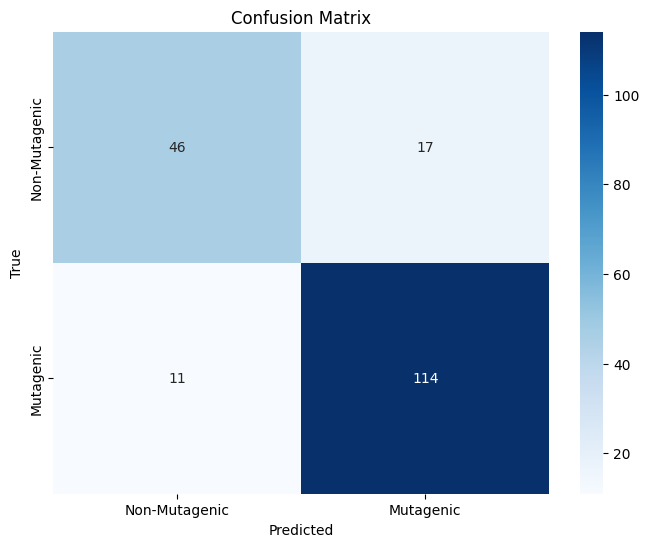

In [ ]:
class_dict={0:'Non-Mutagenic',1:'Mutagenic'}
plot_confusion_matrix(model,dataset,class_dict)

In [ ]:
# Define the path to the local folder on Colab where you want to save the model
save_path = '/content/mutag.pth'

# Save the model
torch.save(model.state_dict(), save_path)

In [1]:

load_path = '/content/mutag.pth'



# Initialize the model architecture

# Load the saved model weights
model.load_state_dict(torch.load(load_path))

# Set the model to evaluation mode
model.eval()


NameError: name 'model' is not defined

# Calculating the Degree Distribution,Cluster Coefficient and Spectral Eigenvalues


In [ ]:
def degree_distribution(data, N):
    # Find all unique nodes present in the edge index tensor
    all_nodes = torch.unique(torch.cat((data.edge_index[0], data.edge_index[1])))

    # Calculate the number of nodes
    num_nodes = int(all_nodes.max()) + 1 if all_nodes.numel() > 0 else 0  # If there are no nodes, set num_nodes to 0

    # Calculate the degree of each node
    degrees = torch.bincount(data.edge_index[0], minlength=num_nodes)

    # Convert degrees to degree distribution
    degree_values = torch.bincount(degrees)

    # Make sure the tensor is of length N
    degree_distribution = torch.cat((degree_values, torch.zeros(max(N - len(degree_values), 0)).to(degree_values.device)))

    return degree_distribution


def clustering_coefficient(data):
    # Ensure the graph is undirected
    #data = to_undirected(data)

    # Calculate the number of nodes
    num_nodes = data.x.shape[0]

    # Calculate the number of triangles each node is involved in
    num_triangles = torch.zeros(num_nodes, dtype=torch.float)

    # Calculate the number of connected triples each node is involved in
    num_connected_triples = torch.zeros(num_nodes, dtype=torch.float)

    # Iterate over each edge in the graph
    for i, j in data.edge_index.t().tolist():
        # Get the neighbors of node i and node j
        neighbors_i = set(data.edge_index[1][data.edge_index[0] == i].tolist())
        neighbors_j = set(data.edge_index[1][data.edge_index[0] == j].tolist())

        # Calculate the number of common neighbors between i and j
        common_neighbors = neighbors_i.intersection(neighbors_j)

        # Update the number of triangles and connected triples for nodes i and j
        num_triangles[i] += len(common_neighbors)
        num_triangles[j] += len(common_neighbors)
        num_connected_triples[i] += len(neighbors_i) - 1
        num_connected_triples[j] += len(neighbors_j) - 1

    # Print intermediate results for debugging
    #print("Number of triangles per node:", num_triangles)
    #print("Number of connected triples per node:", num_connected_triples)

    # Calculate the local clustering coefficient for each node
    local_clustering_coefficient = (num_triangles / 2) / num_connected_triples
    local_clustering_coefficient[torch.isnan(local_clustering_coefficient)] = 0  # Set NaN values to 0

    # Print intermediate results for debugging
    #print("Local clustering coefficient per node:", local_clustering_coefficient)

    # Calculate the average clustering coefficient
    avg_clustering_coefficient = local_clustering_coefficient.mean()

    return avg_clustering_coefficient

def spectrum_distribution(data, k):
    # Convert PyTorch Geometric Data object to a dense adjacency matrix
    num_nodes = data.num_nodes
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index).squeeze(0)

    # Calculate degree matrix
    degree = torch.sum(adj_matrix, dim=1)
    degree_matrix = torch.diag(degree)

    # Calculate Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    # Convert Laplacian to dense matrix and numpy array
    laplacian_dense = laplacian_matrix.numpy()

    # Compute eigenvalues
    eigenvalues, _ = np.linalg.eig(laplacian_dense)

    # Sort eigenvalues in ascending order
    eigenvalues = np.sort(eigenvalues)

    # If k is greater than the number of eigenvalues, pad with zeros
    if k > len(eigenvalues):
        padded_eigenvalues = np.pad(eigenvalues, (0, k - len(eigenvalues)), 'constant')
    else:
        padded_eigenvalues = eigenvalues[:k]

    return padded_eigenvalues

# Example usage
# Assuming 'data' is your PyTorch Geometric Data object and 'k' is the desired number of eigenvalues
# eigenvalues = spectrum_distribution(data, k)






Calculate F1 Score of the Model

In [ ]:
import torch
from sklearn.metrics import f1_score
from torch_geometric.data import DataLoader

def calculate_f1_score(model, dataset):
    model.eval()  # Set model to evaluation mode
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #model.to(device)  # Move model to the appropriate device (GPU if available)

    y_true = []
    y_pred = []

    #loader = DataLoader(dataset, batch_size=1, shuffle=False)
    for data in dataset:
        #data = data.to(device)
        with torch.no_grad():
            _,output = model(data.x, data.edge_index, data.batch)
        predicted_labels = output.argmax(dim=1)
        y_true.append(data.y)
        y_pred.extend(predicted_labels)

    f1 = f1_score(y_true, y_pred, average=None)  # Calculate F1 score
    return f1
f1=calculate_f1_score(model,dataset)
print(f1)


[0.76666667 0.890625  ]


#  Writing the MLE estimates for all the graphs that belong to a class using a

# Graph Representation Model with Categorical Distribution of Nodes and

# Edges

In [ ]:
# Separating the graphs into two classes according to the model
N=28
data1=[]
data2=[]
latent_data1=[]
latent_data2=[]
degreedist1=[]
degreedist2=[]
cluscoeff1=[]
cluscoeff2=[]
spec1=[]
spec2=[]

for i in range(len(dataset)):
    model.eval()
    data=dataset[i]
    embedding , out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    if(pred==0):
        data1.append(data)
        latent_data1.append(embedding)
        degree=degree_distribution(data,N)
        clus=clustering_coefficient(data)
        spec=spectrum_distribution(data,N)
        cluscoeff1.append(clus)
        degreedist1.append(degree)
        spec1.append(spec)

    else:
        data2.append(data)
        latent_data2.append(embedding)
        degree=degree_distribution(data,N)
        degreedist2.append(degree)
        clus=clustering_coefficient(data)
        cluscoeff2.append(clus)
        spec=spectrum_distribution(data,N)
        spec2.append(spec)
print(len(data1))
print(len(data2))

print(data.batch)

latent_explanations=[]


57
131
None


In [ ]:
len(spec1)
len(spec2)

131

In [ ]:
m=torch.nn.Softmax(dim=1)
boundary1=[]
boundary2=[]
boundary3=[]
for i in range(len(dataset)):
    model.eval()
    data=dataset[i]
    embedding , out = model(data.x, data.edge_index, data.batch)
    probs=m(out)
    #out=torch.nn.Softmax(out,dim=0)
    #pred = out.argmax(dim=1)
    if(0.5<probs[0][0]):
        boundary1.append(data)
        #latent_data1.append(embedding)
    if(0.5<probs[0][1]<0.7):
        boundary2.append(data)
    # if(0.4<probs[0][2]<0.6):
    #     boundary3.append(data)
    #     #latent_data2.append(embedding)
print(len(boundary1))
print(len(boundary2))
#print(len(boundary3))
#print(len(boundary))

60
12


In [ ]:
def Dpc(dataset,threshold):
  boundary1=[]
  boundary2=[]
  m=torch.nn.Softmax(dim=1)
  for i in range(len(dataset)):
      model.eval()
      data=dataset[i]
      embedding , out = model(data.x, data.edge_index, data.batch)
      probs=m(out)
      #out=torch.nn.Softmax(out,dim=0)
      #pred = out.argmax(dim=1)
      if(threshold<probs[0][0]):
          boundary1.append(data)
          #latent_data1.append(embedding)
      if(threshold <probs[0][1]):
          boundary2.append(data)
  return boundary1 , boundary2


# Graph Representation Model

In [ ]:
from tqdm import tqdm
import numpy as np

N=28
def GraphRepModel(targetclass,N):
  #N=25 # Number of nodes of the largest graph that the model can generate

  X=np.zeros((N,10))# Node Type Matrix for nodes of 10 types
  #targetclass=data2
  print("length of target class",len(targetclass))

  # #Learning the node representations
  # for i in tqdm(range(len(targetclass))):#len(data1))
  #     data=targetclass[i]
  #     x=data.x
  #     x=np.array(x,dtype=int)

  #     #print(x)
  #     for j in range(len(x)):
  #         X[j][x[j]]+=1
  #     for k in range(j+1,N):
  #         X[k][0]+=1
  for i in tqdm(range(len(targetclass))):#len(data1))
    data=targetclass[i]
    x=data.x
    x=torch.argmax(x, dim=1)
    x=x+1
    #print(x)
    for j in range(len(x)):
        X[j][x[j]]+=1
    for k in range(j+1,N):
        X[k][0]+=1


  #Learning the edge representations
  Adj=np.zeros((N,N))# Edge type count for only two types edge present/edge absent
  for i in tqdm(range(len(targetclass))):
      data=targetclass[i]
      adj=data.edge_index
      rowlen=len(adj[0][:])
      #print(rowlen)
      #print(adj[:][0])
      #print(adj[:][1])
      for j in range(rowlen):
          k1=adj[0][j]
          k2=adj[1][j]
          Adj[k1][k2]+=1
          #Adj[k2][k1]+=1

  #Learning the parameters for the distribution of nodes
  numgraphs=len(targetclass)
  print(numgraphs)
  X=X/numgraphs #converting X to the node distribution matrix

  Adj=Adj/numgraphs
  return X , Adj



# Node Feature and Edge Feature Generative Model

In [ ]:
#B1,AdjB1=GraphRepModel(boundary1,N)
X1,Adj1=GraphRepModel(data1,N)
X2,Adj2=GraphRepModel(data2,N)
# B1,AdjB1=GraphRepModel(boundary1,N)
# B2,AdjB2=GraphRepModel(boundary2,N)



length of target class 57


100%|██████████| 57/57 [00:00<00:00, 2395.11it/s]


57
length of target class 131


100%|██████████| 131/131 [00:00<00:00, 1680.47it/s]

131


# Sampling a Graph from the Generative Model

In [ ]:
from torch.distributions import Categorical
from torch_geometric.utils import subgraph
from torch_geometric.utils import remove_isolated_nodes
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
def graphsampler(N,X,Adj,show=False):
  #torch.manual_seed(sd)
  nodeset=[]
  keepnodes=[]
  newnodes=[]
  count=0

  for i in range(N):
      probs=X[i][:]
      probs=torch.from_numpy(probs)
      m=Categorical(probs)
      chosennode=m.sample()
      nodeset.append(chosennode)
      if(chosennode!=0):
          keepnodes.append(i)
          newnodes.append(chosennode)
  # print("Whole set of nodes ")
  # print(nodeset)
  # print("Nodes to keep")
  # print(keepnodes)
  # print(newnodes)
  #print(Adjacency)
  keepnodescp=keepnodes.copy()
  Adj1=torch.from_numpy(Adj)
  Adjacency= torch.bernoulli(Adj1)
  #Symmetrizing the adjacency matrix as it is a dataset of undirected graphs
  for i in range(N):
    for j in range(i+1):
      Adjacency[i][j]=Adjacency[j][i]
  #print(Adjacency.size())
  # Removing edges generated for absent nodes
  for i in range(len(nodeset)):
    if(nodeset[i]==0):

      Adjacency[i][:]=0
      Adjacency[:][i]=0

  #print("Length of keepnodes list",len(keepnodes))

  templen =  len(keepnodes)
  for j in range(templen):
    testval=0
  # print("value of loop counter j",j)
    place=keepnodes[j]
    #print("corresponding keepnode value",place)
    for k in range(10):
      if(Adjacency[place][k]!=0):
        testval=1
        break
    if(testval==0):
      keepnodescp.remove(place)




  # To test how potent the explainer is we need to feed samples generated from this to the GNN to classify
  #First we need to convert the data into the tensor proper for fitting into the GNN
  edge_ind=Adjacency.nonzero().t().contiguous()
  newgraph=Data(x=nodeset,edge_index=edge_ind)
  # print("Edge index of graph with all nodes")
  # print(edge_ind)
  # #print(newgraph.x)


  # print("Finally nodes that remain in the graph")
  # print(keepnodescp)

  extractededge=subgraph(keepnodescp,edge_ind,relabel_nodes=True)
  extedge=subgraph(keepnodescp,edge_ind,relabel_nodes=False)

  # print("Final edges with nodes same as before")
  # print(extedge[0])
  # print("Final edges with relabelled nodes")
  # print(extractededge[0])
  9163, 0.

  newnodes1=[nodeset[i] for i in keepnodescp]
  newnodes=newnodes1
  newnodes=torch.stack(newnodes)
  newnodes=newnodes-1
  nodelabels=newnodes
  #print(newnodes)
  newnodes=F.one_hot(newnodes,num_classes=7)
  newnodes=newnodes.float()

  #print(newnodes)
  finalgraph=Data(x=newnodes,edge_index=extractededge[0])

  # print(finalgraph.edge_index.type())
  # print(finalgraph.x.type())
  embedding,out=model(finalgraph.x,finalgraph.edge_index,finalgraph.batch)
  soft=torch.nn.Softmax(dim=1)
  #print(soft(out))
  #print(out)
  explainergraph=to_networkx(finalgraph,to_undirected=True)
  problities=soft(out)
  # if problities[0][0]>0.9:
  #     print(problities)
  #     show=True

  if show:
    #nx.draw_networkx(explainergraph, node_size=150, node_color='red',with_labels=False)
    plotmutag(finalgraph)
  degreedist=degree_distribution(finalgraph,N)
  cluscoeffexp=clustering_coefficient(finalgraph)
  specdist=spectrum_distribution(finalgraph,N)
  problities=soft(out)
  explainernodes=nx.number_of_nodes(explainergraph)
  explaineredges=nx.number_of_edges(explainergraph)
  explainerdensity=(explaineredges)/(explainernodes*explainernodes)
  return problities,explainerdensity,embedding,degreedist,cluscoeffexp,specdist

Function for Computing MMD Kernel

In [ ]:
def mmd_kernel(X, Y, kernel_func):
    """
    Compute Maximum Mean Discrepancy (MMD) between two samples using a given kernel function.

    Parameters:
    - X: torch.Tensor, shape (n_samples, n_features)
    - Y: torch.Tensor, shape (m_samples, n_features)
    - kernel_func: function, kernel function to compute pairwise kernel values

    Returns:
    - mmd: float, Maximum Mean Discrepancy
    """
    m, n = len(X), len(Y)

    # Compute kernel matrices
    K_xx = kernel_func(X, X)
    K_yy = kernel_func(Y, Y)
    K_xy = kernel_func(X, Y)

    # Compute MMD statistic
    mmd = 1.0 / (m * (m - 1)) * torch.sum(K_xx - torch.diag(torch.diagonal(K_xx))) + \
          1.0 / (n * (n - 1)) * torch.sum(K_yy - torch.diag(torch.diagonal(K_yy))) - \
          2.0 / (m * n) * torch.sum(K_xy)

    return mmd.item()  # Convert the result to a Python float

# Example of using a Gaussian (RBF) kernel function for PyTorch
def gaussian_kernel(X, Y, sigma=1.0):
    """
    Gaussian (RBF) kernel function.

    Parameters:
    - X: torch.Tensor, shape (n_samples, n_features)
    - Y: torch.Tensor, shape (m_samples, n_features)
    - sigma: float, bandwidth parameter of the kernel

    Returns:
    - K: torch.Tensor, shape (n_samples, m_samples), kernel matrix
    """
    pairwise_sq_dists = torch.sum(X**2, dim=1, keepdim=True) + torch.sum(Y**2, dim=1, keepdim=True).t() - 2 * torch.mm(X, Y.t())
    K = torch.exp(-pairwise_sq_dists / (2.0 * sigma**2))
    return K

# Example usage with PyTorch tensors
torch.manual_seed(42)
sample_X = torch.rand(100, 64)  # Replace with your first sample
sample_Y = torch.rand(50, 64)  # Replace with your second sample

mmd_value = mmd_kernel(sample_X, sample_Y, gaussian_kernel)
print(f'MMD between the two samples: {mmd_value:.4f}')


MMD between the two samples: 0.0001


# Function for Target Class Analysis

In [ ]:
import statistics
import torch

def target_class_analysis(X, Adj, N, latent, numexplanations=50, numsample=10, label=0):
    """
    Analyzes the robustness of a target class in graph data by sampling graphs
    and evaluating accuracy, density, and other metrics.

    Args:
        X: Node feature matrix.
        Adj: Adjacency matrix.
        N: Number of nodes in the graph.
        latent: Latent space embeddings of the original data.
        numexplanations: Number of explanations to generate
        numsample: Number of samples to generate.
        label: Target class label to analyze (default: 0).

    Returns:
        meanaccuracy: Mean accuracy.
        stdaccuracy: Standard deviation of accuracies.
        meandensity: Mean density.
        stddensity: Standard deviation of densities.
        MMD: Maximum Mean Discrepancy (MMD) distance.
        degreedistlist: Degree distributions across samples.
        cluslist: Clustering coefficients across samples.
        speclist: Spectral metrics across samples.
    """
    accuracy = []
    density = []
    embeddings = []
    degreedistlist = []
    cluslist = []
    speclist = []

    for _ in range(numexplanations):
        newX = X  # Placeholder for potential feature perturbation
        newAdj = Adj  # Placeholder for potential adjacency perturbation
        max_prob = 0

        for _ in range(numsample):
            probabilities, explainerdensity, embedding, degreedistb, clus, spec = graphsampler(N, newX, newAdj)

            if probabilities[0][label] > max_prob:
                sampleaccuracy = probabilities[0][label]
                sampledensity = explainerdensity
                sampleembedding = embedding
                sampledeg = degreedistb
                sampleclus = clus
                samplespec = spec
                max_prob = probabilities[0][label]

        accuracy.append(sampleaccuracy)
        density.append(sampledensity)
        embeddings.append(sampleembedding)
        degreedistlist.append(sampledeg)
        cluslist.append(sampleclus)
        speclist.append(samplespec)

    meanaccuracy = torch.mean(torch.tensor(accuracy))
    stdaccuracy = torch.std(torch.tensor(accuracy))
    meandensity = statistics.mean(density)
    stddensity = statistics.stdev(density)

    MMD = mmd_kernel(torch.cat(latent, dim=0), torch.cat(embeddings, dim=0), gaussian_kernel)

    return meanaccuracy, stdaccuracy, meandensity, stddensity, MMD, degreedistlist, cluslist, speclist


Cell Below demonstrates the usage

In [ ]:
meanaccuracy, stdaccuracy, meandensity, stddensity, MMD, degreedistlist, cluslist, speclist= target_class_analysis(X1,Adj1,N,latent_data1,50,20,0)

In [ ]:
print(meanaccuracy,stdaccuracy)

tensor(1.0000) tensor(3.3582e-05)


# Calculating Metrics for  Target Class 1

In [ ]:
import time
start_time=time.time()
meanacc,stdacc, meandensity, stddensity, MMD, deg,cluslist,speclist  =target_class_analysis(X2,Adj2,N,latent_data1,20,1)
print("--- %s seconds ---" % (time.time() - start_time))



--- 38.0731143951416 seconds ---


# Generation of Instances on the Boundary

In [ ]:
p=0.5
X_mixture=p*X1 + (1-p)*X2
P_mixture=p*Adj1 + (1-p)*Adj2
import statistics
import statistics
import torch

def boundaryanalysis(X, Adj, N, numsample, label=0):
    """
    Analyzes the decision boundary of a graph classifier by sampling graphs
    and evaluating accuracy, density, and other metrics.

    Args:
        X: Node feature matrix.
        Adj: Adjacency matrix.
        N: Number of nodes in the graph.
        numsample: Number of samples to generate.
        label: Target class label to analyze (default: 0).

    Returns:
        meanaccuracy: Mean accuracy.
        stdaccuracy: Standard deviation of accuracies.
        meandensity: Mean density.
        stddensity: Standard deviation of densities.
        embeddings: Sample embeddings.
    """
    accuracy = []
    density = []
    embeddings = []

    for _ in range(150):
        newX = X  # Placeholder for potential feature perturbation
        newAdj = Adj  # Placeholder for potential adjacency perturbation
        min_diff = float('inf')

        for _ in range(numsample):
            probabilities, explainerdensity, embedding, degreedistb, clus, spec = graphsampler(N, newX, newAdj)

            diff = abs(probabilities[0][0] - probabilities[0][1])
            if diff < min_diff:
                sampleaccuracy = probabilities[0][label]
                sampledensity = explainerdensity
                sampleembedding = embedding
                min_diff = diff

        accuracy.append(sampleaccuracy)
        density.append(sampledensity)
        embeddings.append(sampleembedding)

    meanaccuracy = torch.mean(torch.tensor(accuracy))
    stdaccuracy = torch.std(torch.tensor(accuracy))
    meandensity = statistics.mean(density)
    stddensity = statistics.stdev(density)

    return meanaccuracy, stdaccuracy, meandensity, stddensity, embeddings





In [ ]:
bdacc,bdstdev,bdden,bddenstddev,boundaryembeddings=boundaryanalysis(X_mixture,P_mixture,N,50,0)

print(bdacc,bdstdev)
print(bdden,bddenstddev)

[tensor(0.5034, grad_fn=<MeanBackward0>), tensor(0.5016, grad_fn=<MeanBackward0>)] [tensor(0.0579, grad_fn=<StdBackward0>), tensor(0.0639, grad_fn=<StdBackward0>)]
[0.09928326740686742, 0.09619108684135186] [0.014074287956343096, 0.0140779370406742]


# Defining and Calculating the Boundary Metrics

In [ ]:
# Computing boundary metrics
import torch
import torch.nn.functional as F

def boundary_margin(embeddings_c1, embeddings_c2):
    """
    Compute the boundary margin.

    Args:
    - embeddings_c1 (torch.Tensor): Embeddings of class c1 graphs.
    - embeddings_c2 (torch.Tensor): Embeddings of boundary graphs between class c1 and c2.

    Returns:
    - margin (float): The boundary margin.

    """
    embeddings_c1=torch.cat(embeddings_c1,dim=0)
    embeddings_c2=torch.cat(embeddings_c2,dim=0)
    distances = torch.norm(embeddings_c1 - embeddings_c2, dim=1)
    margin = torch.min(distances).item()
    return margin

def boundary_thickness(embeddings_c1, embeddings_c1_c2, model, c1, c2, gamma=0.75, num_points=100):
    thickness_values = []

    for emb_c1, emb_c1_c2 in zip(embeddings_c1, embeddings_c1_c2):
        t_values = torch.linspace(0, 1, num_points)
        h_t = (1 - t_values).unsqueeze(1) * emb_c1 + t_values.unsqueeze(1) * emb_c1_c2
        #print(model(h_t).size())

        # Compute the logits
        logits_h_t = model(h_t)  # Assuming `model` is your classifier
        probs_h_t = F.softmax(logits_h_t, dim=1)

        # Compute the integrand
        integrand = (gamma > (probs_h_t[:, c1] - probs_h_t[:, c2])).float()

        # Approximate the integral using the trapezoidal rule
        integral = torch.trapz(integrand, t_values)

        # Compute the thickness value
        thickness_value = (emb_c1 - emb_c1_c2).norm() * integral.mean()
        thickness_values.append(thickness_value.item())

    return sum(thickness_values) / len(thickness_values)

def boundary_complexity(embeddings, D, epsilon=1e-7):
    """
    Compute the boundary complexity.

    Args:
    - embeddings (torch.Tensor): Embeddings of the boundary graphs with shape (num_graphs, embedding_dim).
    - D (int): Dimensionality of the embeddings.
    - epsilon (float): Small value added to eigenvalues to prevent log(0).

    Returns:
    - complexity (float): The boundary complexity.
    """
    # Flatten and concatenate embeddings
    embeddings = torch.cat(embeddings, dim=0)

    # Compute the covariance matrix of the embeddings
    covariance_matrix = torch.cov(embeddings.T)

    # Add a small value to the diagonal for regularization
    covariance_matrix += epsilon * torch.eye(covariance_matrix.size(0))

    # Compute the eigenvalues of the covariance matrix
    eigenvalues = torch.linalg.eigvalsh(covariance_matrix)

    # Clamp eigenvalues to avoid very small negative values due to numerical errors
    eigenvalues = torch.clamp(eigenvalues, min=epsilon)

    # Normalize the eigenvalues
    eigenvalues_normalized = eigenvalues / eigenvalues.sum()

    # Compute the entropy of the normalized eigenvalues
    entropy = -torch.sum(eigenvalues_normalized * torch.log(eigenvalues_normalized + epsilon))

    # Normalize the entropy by dividing it by log(D)
    complexity = entropy / torch.log(torch.tensor(D, dtype=torch.float32))

    return complexity.item()

In [ ]:
latent_data=latent_data2
margin=boundary_margin(boundaryembeddings[:len(latent_data)],latent_data)
print(margin)
thickness=boundary_thickness(boundaryembeddings[:len(latent_data)],latent_data,model.classifier,1,0)
print(thickness)
complexity=boundary_complexity(boundaryembeddings[:len(latent_data)],64)
print(complexity)

4.462556838989258
7.943768188243604
0.39994290471076965


In [ ]:
print("Accuracy is",meanacc,"std is",stdacc)
print("Density is", meandensity,"std is",stddensity)
print("MMD is",MMD)

Accuracy is [tensor(0.9512, grad_fn=<MeanBackward0>), tensor(0.9399, grad_fn=<MeanBackward0>)] std is [tensor(0.0340, grad_fn=<StdBackward0>), tensor(0.0490, grad_fn=<StdBackward0>)]
Density is [0.10860032139577594, 0.10153627180899907] std is [0.008902433175537582, 0.014383968440425476]
MMD is [0.04650883749127388, 0.04313863441348076]


In [ ]:
import torch

def nptotensor(numpy_array_list):
    """
    Convert a list of NumPy arrays to a list of PyTorch tensors.

    Args:
        numpy_array_list (list): List of NumPy arrays.

    Returns:
        list: List of PyTorch tensors.
    """
    return list(map(torch.tensor, numpy_array_list))


MMDdegdist=mmd_kernel(torch.cat(degreedist2,dim=0).view(-1,N),torch.cat(deg,dim=0).view(-1,N),gaussian_kernel)
print(MMDdegdist)
MMDdistclus=mmd_kernel(torch.stack(cluscoeff2).view(-1,1),torch.stack(cluslist).view(-1,1),gaussian_kernel)
print(MMDdistclus)
MMDspec=mmd_kernel(torch.cat(nptotensor(spec2),dim=0).view(-1,N),torch.cat(nptotensor(speclist),dim=0).view(-1,N),gaussian_kernel)
print(MMDspec)

0.12123223394155502
0.0012199878692626953
(0.15383022475918204+5.0662997832216437e-20j)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_with_error(mean, std, threshold, label, numsample,title=None, ax=None):
    """
    Plot mean with error bars.

    Parameters:
        mean (array_like): Array containing mean values.
        std (array_like): Array containing standard deviation values.
        threshold (array_like): Array containing threshold values.
        label (str): Label for the data.
        color (str): Color of the line.
        numsample (int): Sample number.
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. If not provided, a new figure will be created.
    """
    # Flatten the arrays
    mean=torch.tensor(mean,dtype=torch.float32)
    std=torch.tensor(std,dtype=torch.float32)
    mean = np.array(mean).flatten()
    std = np.array(std).flatten()
    threshold = np.array(threshold).flatten()
    # Select color automatically
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    color = colors[numsample % 10]  # Cycle through colors

    # Plotting
    if ax is None:
        fig, ax = plt.subplots()
    ax.errorbar(threshold, mean, yerr=std, fmt='-', color=color, label=f'NumSample={numsample}')  # '-' for line

    # Adding labels and title
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)

    ax.legend(loc='lower right',fontsize='small')  # Show legend
    ax.grid(True)  # Add grid
# Create a figure outside the function
# fig, ax = plt.subplots()
# plot_mean_with_error(Mean1,Std1,Threshold,label='class1',numsample=1,ax=ax)
# plot_mean_with_error(Mean2,Std2,Threshold,label='class1',numsample=2,ax=ax)
# plt.show()


Sensitivity Analysis by varying numsamples and threshold

In [ ]:
import statistics
def sensitivityanalysis(X,Adj,N,numsample,label=0):
  epsilon=0.01
  alpha=0.0
  # perturbedX=perturbX(X,epsilon)
  # perturbedAdj=perturbadj(Adj,epsilon)
  meanaccuracy=[]
  stdaccuracy=[]
  meandensity=[]
  stddensity=[]
  MMD=[]

  while(alpha==0.0):
    accuracy=[]
    density=[]
    embeddings=[]
    for i in range(100):
      newX=X#nodefeatcomb(perturbedX,X,alpha)
      newAdj=Adj#adjcomb(perturbedAdj,Adj,alpha)
      max=0
      for num in range(numsample):
        problities,explainerdensity,embedding=graphsampler(N,newX,newAdj)
        #max=problities[0][label]
        if(problities[0][label]>max):
          sampleaccuracy=problities[0][label]
          sampledensity=explainerdensity
          sampleembedding=embedding
          max=problities[0][label]
      accuracy.append(sampleaccuracy)
      density.append(sampledensity)
      embeddings.append(sampleembedding)
    meanacc=torch.mean(torch.stack(accuracy))
    stdacc=torch.std(torch.stack(accuracy))
    meanden=statistics.mean(density)
    stdden=statistics.stdev(density)
    meanaccuracy.append(meanacc)
    stdaccuracy.append(stdacc)
    # meandensity.append(meanden)
    # stddensity.append(stdden)
    # MMDdist=mmd_kernel(torch.cat(latent,dim=0),torch.cat(embeddings,dim=0),gaussian_kernel)
    # MMD.append(MMDdist)
    alpha+=0.05
  return meanaccuracy , stdaccuracy

length of target class 60


100%|██████████| 60/60 [00:00<00:00, 1820.93it/s]


60
length of target class 128


100%|██████████| 128/128 [00:00<00:00, 1700.53it/s]

128


length of target class 50


100%|██████████| 50/50 [00:00<00:00, 2185.88it/s]


50
length of target class 127


100%|██████████| 127/127 [00:00<00:00, 1691.54it/s]

127


length of target class 49


100%|██████████| 49/49 [00:00<00:00, 2524.98it/s]


49
length of target class 126


100%|██████████| 126/126 [00:00<00:00, 1691.24it/s]

126


length of target class 44


100%|██████████| 44/44 [00:00<00:00, 1666.01it/s]


44
length of target class 124


100%|██████████| 124/124 [00:00<00:00, 1272.51it/s]

124


length of target class 38


100%|██████████| 38/38 [00:00<00:00, 1793.37it/s]


38
length of target class 116


100%|██████████| 116/116 [00:00<00:00, 1606.91it/s]

116


length of target class 29


100%|██████████| 29/29 [00:00<00:00, 2128.23it/s]


29
length of target class 97


100%|██████████| 97/97 [00:00<00:00, 1574.25it/s]

97


length of target class 26


100%|██████████| 26/26 [00:00<00:00, 1117.55it/s]


26
length of target class 78


100%|██████████| 78/78 [00:00<00:00, 865.09it/s]

78


length of target class 14


100%|██████████| 14/14 [00:00<00:00, 1266.86it/s]


14
length of target class 66


100%|██████████| 66/66 [00:00<00:00, 824.48it/s]

66


length of target class 10


100%|██████████| 10/10 [00:00<00:00, 1652.21it/s]


10
length of target class 41


100%|██████████| 41/41 [00:00<00:00, 1126.16it/s]

41


length of target class 3


100%|██████████| 3/3 [00:00<00:00, 620.92it/s]


3
length of target class 21


100%|██████████| 21/21 [00:00<00:00, 834.70it/s]

21


length of target class 60


100%|██████████| 60/60 [00:00<00:00, 2408.90it/s]


60
length of target class 128


100%|██████████| 128/128 [00:00<00:00, 964.19it/s] 


128
length of target class 50


100%|██████████| 50/50 [00:00<00:00, 2133.57it/s]


50
length of target class 127


100%|██████████| 127/127 [00:00<00:00, 1591.77it/s]

127


length of target class 49


100%|██████████| 49/49 [00:00<00:00, 2453.48it/s]


49
length of target class 126


100%|██████████| 126/126 [00:00<00:00, 1742.40it/s]

126


length of target class 44


100%|██████████| 44/44 [00:00<00:00, 2091.97it/s]


44
length of target class 124


100%|██████████| 124/124 [00:00<00:00, 1602.02it/s]

124


length of target class 38


100%|██████████| 38/38 [00:00<00:00, 1575.42it/s]


38
length of target class 116


100%|██████████| 116/116 [00:00<00:00, 1039.60it/s]

116


length of target class 29


100%|██████████| 29/29 [00:00<00:00, 1444.30it/s]


29
length of target class 97


100%|██████████| 97/97 [00:00<00:00, 1149.59it/s]

97


length of target class 26


100%|██████████| 26/26 [00:00<00:00, 2056.03it/s]


26
length of target class 78


100%|██████████| 78/78 [00:00<00:00, 1557.93it/s]

78


length of target class 14


100%|██████████| 14/14 [00:00<00:00, 1292.54it/s]


14
length of target class 66


100%|██████████| 66/66 [00:00<00:00, 1551.10it/s]

66


length of target class 10


100%|██████████| 10/10 [00:00<00:00, 1380.66it/s]


10
length of target class 41


100%|██████████| 41/41 [00:00<00:00, 1047.46it/s]

41


length of target class 3


100%|██████████| 3/3 [00:00<00:00, 1190.55it/s]


3
length of target class 21


100%|██████████| 21/21 [00:00<00:00, 668.21it/s]

21


length of target class 60


100%|██████████| 60/60 [00:00<00:00, 2049.43it/s]


60
length of target class 128


100%|██████████| 128/128 [00:00<00:00, 1667.33it/s]

128


length of target class 50


100%|██████████| 50/50 [00:00<00:00, 1850.60it/s]


50
length of target class 127


100%|██████████| 127/127 [00:00<00:00, 1728.64it/s]

127


length of target class 49


100%|██████████| 49/49 [00:00<00:00, 2405.81it/s]


49
length of target class 126


100%|██████████| 126/126 [00:00<00:00, 1491.78it/s]

126


length of target class 44


100%|██████████| 44/44 [00:00<00:00, 2177.14it/s]


44
length of target class 124


100%|██████████| 124/124 [00:00<00:00, 1576.74it/s]

124


length of target class 38


100%|██████████| 38/38 [00:00<00:00, 1920.86it/s]


38
length of target class 116


100%|██████████| 116/116 [00:00<00:00, 1560.35it/s]

116


length of target class 29


100%|██████████| 29/29 [00:00<00:00, 1692.85it/s]


29
length of target class 97


100%|██████████| 97/97 [00:00<00:00, 1589.18it/s]

97


length of target class 26


100%|██████████| 26/26 [00:00<00:00, 1440.58it/s]


26
length of target class 78


100%|██████████| 78/78 [00:00<00:00, 1513.21it/s]

78


length of target class 14


100%|██████████| 14/14 [00:00<00:00, 1535.37it/s]


14
length of target class 66


100%|██████████| 66/66 [00:00<00:00, 1356.93it/s]

66


length of target class 10


100%|██████████| 10/10 [00:00<00:00, 1142.80it/s]


10
length of target class 41


100%|██████████| 41/41 [00:00<00:00, 1031.45it/s]

41


length of target class 3


100%|██████████| 3/3 [00:00<00:00, 1255.03it/s]


3
length of target class 21


100%|██████████| 21/21 [00:00<00:00, 715.63it/s]

21


length of target class 60


100%|██████████| 60/60 [00:00<00:00, 2261.18it/s]


60
length of target class 128


100%|██████████| 128/128 [00:00<00:00, 1582.24it/s]

128


length of target class 50


100%|██████████| 50/50 [00:00<00:00, 1567.87it/s]


50
length of target class 127


100%|██████████| 127/127 [00:00<00:00, 937.44it/s]


127
length of target class 49


100%|██████████| 49/49 [00:00<00:00, 1892.39it/s]


49
length of target class 126


100%|██████████| 126/126 [00:00<00:00, 1634.87it/s]

126


length of target class 44


100%|██████████| 44/44 [00:00<00:00, 2399.36it/s]


44
length of target class 124


100%|██████████| 124/124 [00:00<00:00, 1469.11it/s]

124


length of target class 38


100%|██████████| 38/38 [00:00<00:00, 1902.29it/s]


38
length of target class 116


100%|██████████| 116/116 [00:00<00:00, 1617.46it/s]

116


length of target class 29


100%|██████████| 29/29 [00:00<00:00, 1209.41it/s]


29
length of target class 97


100%|██████████| 97/97 [00:00<00:00, 932.21it/s]

97


length of target class 26


100%|██████████| 26/26 [00:00<00:00, 1236.32it/s]


26
length of target class 78


100%|██████████| 78/78 [00:00<00:00, 1534.94it/s]

78


length of target class 14


100%|██████████| 14/14 [00:00<00:00, 1421.38it/s]


14
length of target class 66


100%|██████████| 66/66 [00:00<00:00, 1150.66it/s]

66


length of target class 10


100%|██████████| 10/10 [00:00<00:00, 1470.71it/s]


10
length of target class 41


100%|██████████| 41/41 [00:00<00:00, 799.97it/s]

41


length of target class 3


100%|██████████| 3/3 [00:00<00:00, 520.17it/s]


3
length of target class 21


100%|██████████| 21/21 [00:00<00:00, 616.63it/s]

21


length of target class 60


100%|██████████| 60/60 [00:00<00:00, 2029.35it/s]


60
length of target class 128


100%|██████████| 128/128 [00:00<00:00, 1577.68it/s]

128


length of target class 50


100%|██████████| 50/50 [00:00<00:00, 2333.07it/s]


50
length of target class 127


100%|██████████| 127/127 [00:00<00:00, 1585.22it/s]

127


length of target class 49


100%|██████████| 49/49 [00:00<00:00, 1669.16it/s]


49
length of target class 126


100%|██████████| 126/126 [00:00<00:00, 1521.96it/s]

126


length of target class 44


100%|██████████| 44/44 [00:00<00:00, 2018.50it/s]


44
length of target class 124


100%|██████████| 124/124 [00:00<00:00, 1352.03it/s]

124


length of target class 38


100%|██████████| 38/38 [00:00<00:00, 1814.21it/s]


38
length of target class 116


100%|██████████| 116/116 [00:00<00:00, 1613.93it/s]

116


length of target class 29


100%|██████████| 29/29 [00:00<00:00, 1403.33it/s]


29
length of target class 97


100%|██████████| 97/97 [00:00<00:00, 1000.57it/s]

97


length of target class 26


100%|██████████| 26/26 [00:00<00:00, 1216.00it/s]


26
length of target class 78


100%|██████████| 78/78 [00:00<00:00, 836.14it/s]

78


length of target class 14


100%|██████████| 14/14 [00:00<00:00, 1294.11it/s]


14
length of target class 66


100%|██████████| 66/66 [00:00<00:00, 892.58it/s]

66


length of target class 10


100%|██████████| 10/10 [00:00<00:00, 675.16it/s]


10
length of target class 41


100%|██████████| 41/41 [00:00<00:00, 584.32it/s]

41


length of target class 3


100%|██████████| 3/3 [00:00<00:00, 1280.31it/s]


3
length of target class 21


100%|██████████| 21/21 [00:00<00:00, 706.28it/s]

21


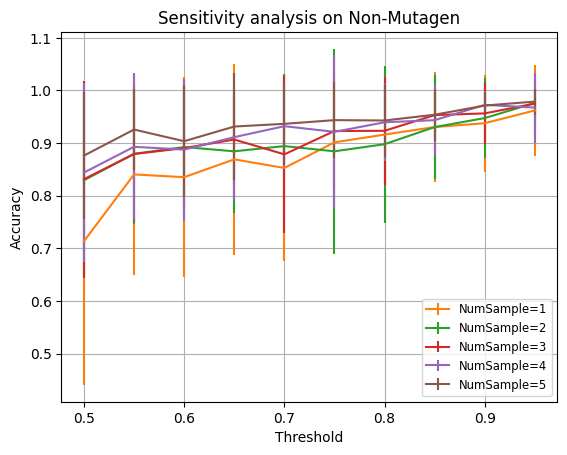

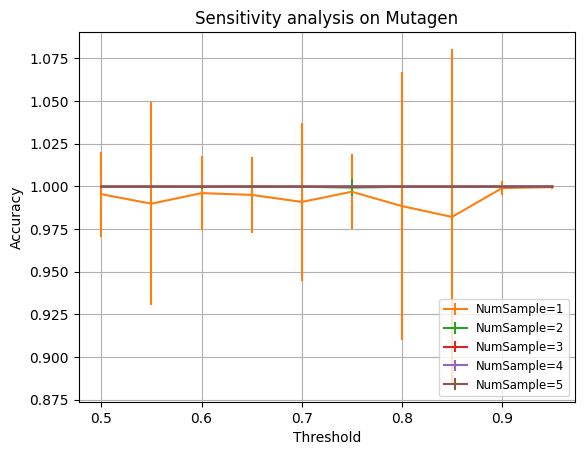

In [ ]:
samplerange=6
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
for numsample in range(1,samplerange):
  threshold=0.5
  Threshold=[]
  Mean1=[]
  Std1=[]
  Mean2=[]
  Std2=[]
  while(threshold<1):
    Threshold.append(threshold)
    data1 , data2=Dpc(dataset,threshold)
    X1,Adj1=GraphRepModel(data1,N)
    X2,Adj2=GraphRepModel(data2,N)
    mean1,std1=sensitivityanalysis(X1,Adj1,N,numsample+5,0)
    Mean1.append(mean1)
    Std1.append(std1)
    mean2,std2=sensitivityanalysis(X2,Adj2,N,numsample,1)
    Mean2.append(mean2)
    Std2.append(std2)
    threshold+=0.05
  plot_mean_with_error(Mean1,Std1,Threshold,label='class1',numsample=numsample,title='Sensitivity analysis on Non-Mutagen',ax=ax1)
  plot_mean_with_error(Mean2,Std2,Threshold,label='class2',numsample=numsample,title='Sensitivity analysis on Mutagen',ax=ax2)

plt.show()

